In [36]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from pyomo.environ import (
    ConcreteModel, Var, Param, Constraint, Objective, RangeSet,
    minimize, SolverFactory, value, exp, Suffix
)
from pyomo.common.tempfiles import TempfileManager
from pyomo.opt import TerminationCondition

import time
from pyomo.common.tempfiles import TempfileManager
from pyomo.opt import TerminationCondition

def ipopt_solve_with_stats(model, solver, max_iter=500, max_cpu_time=120, tee=False):
    """
    Solve with IPOPT and parse its output file to get:
      - status_obj: full Pyomo result
      - solved: bool (termination_condition == optimal)
      - iters: IPOPT "Number of Iterations"
      - cpu_time: IPOPT CPU time (internal + function evals), if parsed
      - regu: regularization value at solution (optional / may be None)
      - wall_time: Python wall-clock time for solver.solve(...)
    """
    TempfileManager.push()
    tempfile = TempfileManager.create_tempfile(suffix='ipopt_out', text=True)

    # Per-call overrides; solver.options (mu_init, etc.) still apply
    opts = {
        'output_file': tempfile,
        'max_iter': max_iter,
        'max_cpu_time': max_cpu_time,
    }

    # Wall-clock timer around solve
    t0 = time.perf_counter()
    status_obj = solver.solve(model, options=opts, tee=tee)
    t1 = time.perf_counter()
    wall_time = t1 - t0

    solved = (status_obj.solver.termination_condition == TerminationCondition.optimal)

    iters = 0
    cpu_time = 0.0
    regu = None

    # Parse IPOPT output file
    with open(tempfile, 'r') as f:
        line_m_2 = None
        line_m_1 = None
        for line in f:
            line_stripped = line.strip()

            # Iteration count
            if line_stripped.startswith('Number of Iterations'):
                # e.g. "Number of Iterations....:      23"
                tokens = line_stripped.split()
                iters = int(tokens[-1])

                # Optional: regu from two lines above, if present in your IPOPT build
                if line_m_2 is not None:
                    # This depends heavily on your IPOPT build; safe to leave None
                    regu = line_m_2.strip()

            # CPU time (two lines)
            elif 'Total CPU secs in IPOPT (w/o function evaluations)' in line_stripped:
                tokens = line_stripped.split()
                # last token should be the numeric time
                try:
                    cpu_time += float(tokens[-1])
                except ValueError:
                    pass  # format unexpected, keep going

            elif 'Total CPU secs in NLP function evaluations' in line_stripped:
                tokens = line_stripped.split()
                try:
                    cpu_time += float(tokens[-1])
                except ValueError:
                    pass

            line_m_2 = line_m_1
            line_m_1 = line

    TempfileManager.pop(remove=True)

    # If CPU time parsing failed, you still have wall_time as a fallback
    return status_obj, solved, iters, cpu_time, regu, wall_time

# ============================================================
# Problem parameters
# ============================================================
D_tube = 0.126
A_t = math.pi * (D_tube / 2.0) ** 2

params = {
    # geometry
    "A_t":   A_t,

    # inlet
    "cA_in": 80.0,
    "cB_in": 0.0,
    "cC_in": 0.0,
    "T_in":  423.0,

    # kinetics
    "Rgas":  8.314,
    "k01":   0.1,          # 1/h
    "E1":    33475.0,      # J/mol
    "k02":   9.0e-7,       # m^3/(mol*h)
    "E2":    75319.0,      # J/mol

    # heats of reaction (exothermic)
    "dH1":  -20.0e3,       # J/mol
    "dH2":  -60.0e3,       # J/mol

    # heat transfer per volume + volumetric heat capacity
    "Ua":    8524.0 * 1e3, # J/(m^3*h*K)
    "rhoCp": 8.0e5,        # J/(m^3*K)

    # MV bounds
    "F_min":   0.6,
    "F_max":   2.5,
    "Tj_min":  298.0,
    "Tj_max":  600.0,

    # path/safety bounds on Tr
    "T_lo": 280.0,
    "T_hi": 700.0,
}

# ============================================================
# Helper: zone mapping along the reactor
# ============================================================
def _build_zone_sampling(L, N, n_zones):
    """Return (zone_bounds, z_nodes, node_zone) given reactor length L and N nodes."""
    zone_bounds = np.linspace(0.0, L, n_zones + 1)  # 0, L/5, 2L/5, ..., L
    dz = L / (N - 1)
    z_nodes = np.array([i * dz for i in range(N)])

    def zone_of_z(z):
        # return 1..5 for z in each segment (rightmost inclusive)
        for zi in range(n_zones):
            if (z >= zone_bounds[zi]) and (z <= zone_bounds[zi + 1] + 1e-12):
                return zi + 1
        return n_zones

    node_zone = {i: zone_of_z(z_nodes[i]) for i in range(N)}
    return zone_bounds, z_nodes, node_zone


# ============================================================
# PFR environment (IPOPT-backed)
# ============================================================
class PfrIpoptEnv:
    """
    Environment for the PFR optimal control problem NLP solved by IPOPT.

    - Build the Pyomo model once in __init__
    - reset(s0): solve for an initial setpoint s0 (fresh ICs)
    - step(s_new): change setpoint, continue from previous terminal state
    """

    def __init__(
            self,
            params,
            N=30,
            K=30,
            L=20.0,
            dt=0.02,
            target_species="B",
            n_zones=5,
            ipopt_options=None,
            use_warm_start=False,
            cold_reset_vars=False,
    ):
        # problem specifics
        self.params = params
        self.N = N
        self.K = K
        self.L = L
        self.dt = dt
        self.dz = L / (N - 1)
        self.target_species = target_species
        self.n_zones = n_zones

        self.use_warm_start = use_warm_start
        self.cold_reset_vars = cold_reset_vars

        # grid + zones
        self.zone_bounds, self.z_nodes, self.node_zone = _build_zone_sampling(L, N, n_zones)

        # build pyomo model
        self.m = self._build_model()

        # IPOPT solver
        self.solver = SolverFactory('ipopt')
        default_opts = {
            'tol': 1e-6,
            'linear_solver': 'mumps',
            'mu_init': 1e-2,
            'print_level': 5,
            'max_iter': 500,
        }
        if ipopt_options:
            default_opts.update(ipopt_options)
        self.solver.options.update(default_opts)

        # If we want IPOPT warm-start support, turn it on
        if self.use_warm_start:
            self.solver.options["warm_start_init_point"] = "yes"
            # these can be tuned, but these are standard-ish
            self.solver.options["warm_start_bound_push"] = 1e-6
            self.solver.options["warm_start_mult_bound_push"] = 1e-6

        # bookkeeping
        self.prev_results = None
        self.prev_setpoint = None
        self.current_setpoint = None

    # ---------------- Model builder ----------------
    def _build_model(self):
        N = self.N
        K = self.K
        dt = self.dt
        dz = self.dz
        target_species = self.target_species

        m = ConcreteModel()

        # index sets
        m.I = RangeSet(0, N - 1)         # space nodes
        m.K = RangeSet(0, K)             # time nodes
        m.Z = RangeSet(1, self.n_zones)

        # setpoint as mutable parameter
        m.s = Param(initialize=40.0, mutable=True)

        # initial-condition parameters (mutable, so we can continue between solves)
        cA0_init = {i: (self.params["cA_in"] if i == 0 else 0.0) for i in range(N)}
        cB0_init = {i: self.params["cB_in"] for i in range(N)}
        cC0_init = {i: self.params["cC_in"] for i in range(N)}
        Tr0_init = {i: self.params["T_in"] for i in range(N)}

        m.cA0 = Param(m.I, initialize=cA0_init, mutable=True)
        m.cB0 = Param(m.I, initialize=cB0_init, mutable=True)
        m.cC0 = Param(m.I, initialize=cC0_init, mutable=True)
        m.Tr0 = Param(m.I, initialize=Tr0_init, mutable=True)

        # states
        m.cA = Var(m.I, m.K, bounds=(0.0, None), initialize=self.params["cA_in"])
        m.cB = Var(m.I, m.K, bounds=(0.0, None), initialize=0.0)
        m.cC = Var(m.I, m.K, bounds=(0.0, None), initialize=0.0)
        m.Tr = Var(
            m.I, m.K,
            bounds=(self.params["T_lo"], self.params["T_hi"]),
            initialize=self.params["T_in"]
        )

        # manipulated vars
        m.F = Var(
            m.K,
            bounds=(self.params["F_min"], self.params["F_max"]),
            initialize=1.2
        )
        m.Tj = Var(
            m.Z, m.K,
            bounds=(self.params["Tj_min"], self.params["Tj_max"]),
            initialize=350.0
        )

        # helper: jacket T at node i, time k
        def Tj_at(m, i, k):
            return m.Tj[self.node_zone[int(i)], k]

        # Initial conditions at t=0 (use IC Params)
        def ic_cA(m, i): return m.cA[i, 0] == m.cA0[i]
        def ic_cB(m, i): return m.cB[i, 0] == m.cB0[i]
        def ic_cC(m, i): return m.cC[i, 0] == m.cC0[i]
        def ic_Tr(m, i): return m.Tr[i, 0] == m.Tr0[i]

        m.icA  = Constraint(m.I, rule=ic_cA)
        m.icB  = Constraint(m.I, rule=ic_cB)
        m.icC  = Constraint(m.I, rule=ic_cC)
        m.icTr = Constraint(m.I, rule=ic_Tr)

        # Inlet BC for all k
        def bcA_in(m, k): return m.cA[0, k] == self.params["cA_in"]
        def bcB_in(m, k): return m.cB[0, k] == self.params["cB_in"]
        def bcC_in(m, k): return m.cC[0, k] == self.params["cC_in"]
        def bcT_in(m, k): return m.Tr[0, k] == self.params["T_in"]

        m.bcA = Constraint(m.K, rule=bcA_in)
        m.bcB = Constraint(m.K, rule=bcB_in)
        m.bcC = Constraint(m.K, rule=bcC_in)
        m.bcT = Constraint(m.K, rule=bcT_in)

        # Arrhenius rates
        def R1(m, i, k1):
            T = m.Tr[i, k1]
            return (self.params["k01"] *
                    exp((self.params["E1"] / self.params["Rgas"]) *
                        (1.0 / 300.0 - 1.0 / T)) *
                    m.cA[i, k1])

        def R2(m, i, k1):
            T = m.Tr[i, k1]
            return (self.params["k02"] *
                    exp((self.params["E2"] / self.params["Rgas"]) *
                        (1.0 / 300.0 - 1.0 / T)) *
                    (m.cA[i, k1] ** 2))

        # convective velocity helper
        def u_at(m, k1):
            return m.F[k1] / self.params["A_t"]

        # PDE constraints (implicit Euler in time, upwind in space)
        def pde_cA(m, i, k):
            if i == 0 or k == K:
                return Constraint.Skip
            k1 = k + 1
            u = u_at(m, k1)
            conv = u * (m.cA[i, k1] - m.cA[i - 1, k1]) / self.dz
            return (m.cA[i, k1] - m.cA[i, k]) / self.dt + conv + (R1(m, i, k1) + R2(m, i, k1)) == 0.0

        def pde_cB(m, i, k):
            if i == 0 or k == K:
                return Constraint.Skip
            k1 = k + 1
            u = u_at(m, k1)
            conv = u * (m.cB[i, k1] - m.cB[i - 1, k1]) / self.dz
            return (m.cB[i, k1] - m.cB[i, k]) / self.dt + conv - R1(m, i, k1) == 0.0

        def pde_cC(m, i, k):
            if i == 0 or k == K:
                return Constraint.Skip
            k1 = k + 1
            u = u_at(m, k1)
            conv = u * (m.cC[i, k1] - m.cC[i - 1, k1]) / self.dz
            return (m.cC[i, k1] - m.cC[i, k]) / self.dt + conv - 0.5 * R2(m, i, k1) == 0.0

        def pde_T(m, i, k):
            if i == 0 or k == K:
                return Constraint.Skip
            k1 = k + 1
            u = u_at(m, k1)
            conv = u * (m.Tr[i, k1] - m.Tr[i - 1, k1]) / self.dz
            q_rxn = (-self.params["dH1"]) * R1(m, i, k1) + (-self.params["dH2"]) * R2(m, i, k1)
            q_ht = self.params["Ua"] * (Tj_at(m, i, k1) - m.Tr[i, k1])
            return (m.Tr[i, k1] - m.Tr[i, k]) / self.dt + conv - (q_rxn + q_ht) / self.params["rhoCp"] == 0.0

        m.pdeA = Constraint(m.I, m.K, rule=pde_cA)
        m.pdeB = Constraint(m.I, m.K, rule=pde_cB)
        m.pdeC = Constraint(m.I, m.K, rule=pde_cC)
        m.pdeT = Constraint(m.I, m.K, rule=pde_T)

        # outlet + objective
        out_idx = N - 1

        def y_of_k(m, k):
            if target_species.upper() == 'B':
                return m.cB[out_idx, k]
            else:
                return m.cC[out_idx, k]

        def obj_rule(m):
            return sum((y_of_k(m, k) - m.s) ** 2 for k in m.K) * self.dt

        m.obj = Objective(rule=obj_rule, sense=minimize)

        # --- IPOPT suffixes for (optional) warm-start ---
        # duals for constraints
        m.dual = Suffix(direction=Suffix.IMPORT_EXPORT)
        # bound multipliers
        m.ipopt_zL_out = Suffix(direction=Suffix.IMPORT)
        m.ipopt_zU_out = Suffix(direction=Suffix.IMPORT)
        m.ipopt_zL_in  = Suffix(direction=Suffix.EXPORT)
        m.ipopt_zU_in  = Suffix(direction=Suffix.EXPORT)

        return m


    def _copy_ipopt_multipliers_for_warm_start(self):
        """
        After a solve, copy ipopt_z*_out into ipopt_z*_in so that
        the NEXT solve can reuse bound multipliers.

        Primal variables and constraint duals (m.dual) already
        stay on the model.
        """
        if not self.use_warm_start:
            return
        m = self.m
        for v in m.component_data_objects(Var, active=True):
            if v in m.ipopt_zL_out:
                m.ipopt_zL_in[v] = m.ipopt_zL_out[v]
            if v in m.ipopt_zU_out:
                m.ipopt_zU_in[v] = m.ipopt_zU_out[v]

    def _reset_decision_variables(self):
        """
        For 'cold' runs, reset all decision variables to a simple
        nominal guess before each solve.
        This removes primal warm-start.
        """
        if not self.cold_reset_vars:
            return
        m = self.m
        # states
        for i in m.I:
            for k in m.K:
                idx = int(i)
                m.cA[i, k].set_value(self.params["cA_in"] if idx == 0 else 0.0)
                m.cB[i, k].set_value(self.params["cB_in"])
                m.cC[i, k].set_value(self.params["cC_in"])
                m.Tr[i, k].set_value(self.params["T_in"])
        # manipulated vars
        for k in m.K:
            m.F[k].set_value(1.2)
            for z in m.Z:
                m.Tj[z, k].set_value(350.0)

    # ---------------- solving helper ----------------
    def _solve_current_nlp(self, tee=True):
        m = self.m
        N = self.N
        K = self.K
        dt = self.dt
        n_zones = self.n_zones
        target_species = self.target_species
        s_val = float(m.s.value)

        # For cold runs, reset primal guess each time
        self._reset_decision_variables()

        # Solve with stats (iterations + CPU time)
        status_obj, solved, iters, solve_time, regu, wall_time = ipopt_solve_with_stats(
            m, self.solver, max_iter=500, max_cpu_time=120, tee=tee
        )

        # Collect arrays
        z = self.z_nodes
        t = np.array([k * dt for k in range(K + 1)])

        cA = np.array([[value(m.cA[i, k]) for k in m.K] for i in m.I])
        cB = np.array([[value(m.cB[i, k]) for k in m.K] for i in m.I])
        cC = np.array([[value(m.cC[i, k]) for k in m.K] for i in m.I])
        Tr = np.array([[value(m.Tr[i, k]) for k in m.K] for i in m.I])

        F = np.array([value(m.F[k]) for k in m.K])
        Tj = np.zeros((n_zones, K + 1))
        for zi in range(1, n_zones + 1):
            Tj[zi - 1, :] = np.array([value(m.Tj[zi, k]) for k in m.K])

        if target_species.upper() == 'B':
            y_out = cB[-1, :]
        else:
            y_out = cC[-1, :]

        l2 = math.sqrt(np.sum((y_out - s_val) ** 2) * dt)

        results = dict(
            z=z, t=t,
            cA=cA, cB=cB, cC=cC, Tr=Tr,
            F=F, Tj=Tj,
            y_out=y_out,
            l2=l2,
            solve_time=wall_time,
            iters=iters,           # <-- NEW
            solved=solved,
            regu=regu,
            solver_status=status_obj,
            setpoint=s_val
        )

        print(
            f"[PFR ENV] s={s_val:.2f}, L2={l2:.3e}, "
            f"iters={iters:d}, solve_time={wall_time:.3f} s, "
            f"solved={solved}"
        )

        # prepare for warm-start in NEXT solve
        self._copy_ipopt_multipliers_for_warm_start()

        return results


    # -------------- IC update between solves --------------
    def _update_initial_state_from_results(self, results):
        m = self.m
        cA_end = results["cA"][:, -1]
        cB_end = results["cB"][:, -1]
        cC_end = results["cC"][:, -1]
        Tr_end = results["Tr"][:, -1]

        for i in m.I:
            idx = int(i)
            m.cA0[i].set_value(float(cA_end[idx]))
            m.cB0[i].set_value(float(cB_end[idx]))
            m.cC0[i].set_value(float(cC_end[idx]))
            m.Tr0[i].set_value(float(Tr_end[idx]))

    # ---------------- reset / step ----------------
    def reset(self, s0, tee=False):
        m = self.m
        # fresh “empty” reactor
        for i in m.I:
            idx = int(i)
            m.cA0[i].set_value(self.params["cA_in"] if idx == 0 else 0.0)
            m.cB0[i].set_value(self.params["cB_in"])
            m.cC0[i].set_value(self.params["cC_in"])
            m.Tr0[i].set_value(self.params["T_in"])

        m.s.set_value(s0)
        self.current_setpoint = s0

        # reset primal guess if cold mode
        self._reset_decision_variables()

        results = self._solve_current_nlp(tee=tee)
        self.prev_results = results
        self.prev_setpoint = s0
        self._update_initial_state_from_results(results)

        return results


    def step(self, s_new, tee=False):
        self.m.s.set_value(s_new)
        self.current_setpoint = s_new

        results = self._solve_current_nlp(tee=tee)

        self.prev_results = results
        self.prev_setpoint = s_new
        self._update_initial_state_from_results(results)

        return results

    def get_last_results(self):
        return self.prev_results


# ============================================================
# Run a setpoint sequence
# ============================================================
def run_setpoint_sequence(env, setpoints, tee=False):
    all_results = []
    meta_list = []

    s0 = float(setpoints[0])
    res0 = env.reset(s0, tee=tee)
    all_results.append(res0)
    meta_list.append({
        "setpoint": s0,
        "l2": res0["l2"],
        "solve_time": res0["solve_time"],
        "iters": res0["iters"],        # <-- NEW
    })

    for s in setpoints[1:]:
        s_val = float(s)
        res = env.step(s_val, tee=tee)
        all_results.append(res)
        meta_list.append({
            "setpoint": s_val,
            "l2": res["l2"],
            "solve_time": res["solve_time"],
            "iters": res["iters"],     # <-- NEW
        })

    total_time = sum(d["solve_time"] for d in meta_list)
    total_iters = sum(d["iters"] for d in meta_list)
    print(f"total run time = {total_time:.3f} seconds, "
          f"total iterations = {total_iters:d}")

    return all_results, meta_list



# ============================================================
# Stitch sequence into one long trajectory
# ============================================================
def stitch_results_sequence(all_results):
    """
    Take list of per-solve results and build one global-time trajectory.
    Avoids duplicating the end point between runs.
    """
    first = all_results[0]
    z = first["z"]
    n_zones = first["Tj"].shape[0]

    t_list   = []
    F_list   = []
    Tj_list  = []
    cA_list  = []
    cB_list  = []
    cC_list  = []
    Tr_list  = []

    T_block = first["t"][-1]

    for j, res in enumerate(all_results):
        t_local = res["t"]
        F_local = res["F"]
        Tj_local = res["Tj"]
        cA_local = res["cA"]
        cB_local = res["cB"]
        cC_local = res["cC"]
        Tr_local = res["Tr"]

        # shift time for this run
        t_shift = t_local + j * T_block

        # avoid repeating t=0 for subsequent runs
        if j == 0:
            sl = slice(None)
        else:
            sl = slice(1, None)

        t_list.append(t_shift[sl])
        F_list.append(F_local[sl])
        Tj_list.append(Tj_local[:, sl])
        cA_list.append(cA_local[:, sl])
        cB_list.append(cB_local[:, sl])
        cC_list.append(cC_local[:, sl])
        Tr_list.append(Tr_local[:, sl])

    t   = np.concatenate(t_list)
    F   = np.concatenate(F_list)
    Tj  = np.concatenate(Tj_list, axis=1)
    cA  = np.concatenate(cA_list, axis=1)
    cB  = np.concatenate(cB_list, axis=1)
    cC  = np.concatenate(cC_list, axis=1)
    Tr  = np.concatenate(Tr_list, axis=1)

    return dict(
        z=z, t=t,
        F=F, Tj=Tj,
        cA=cA, cB=cB, cC=cC, Tr=Tr,
    )


# ============================================================
# Plotting helpers
# ============================================================
def plot_meta_over_solves(meta_list):
    idx = np.arange(len(meta_list))
    l2_vals = np.array([d["l2"] for d in meta_list])
    t_vals  = np.array([d["solve_time"] for d in meta_list])
    s_vals  = np.array([d["setpoint"] for d in meta_list])

    plt.figure(figsize=(6, 3))
    plt.step(idx, l2_vals, where="mid")
    plt.xlabel("solve index")
    plt.ylabel("L2 tracking error")
    plt.title("NLP L2 error vs solve index")
    plt.tight_layout()

    plt.figure(figsize=(6, 3))
    plt.step(idx, t_vals, where="mid")
    plt.xlabel("solve index")
    plt.ylabel("solve time (s)")
    plt.title("NLP solve time vs solve index")
    plt.tight_layout()

    plt.figure(figsize=(6, 3))
    plt.step(idx, s_vals, where="mid")
    plt.xlabel("solve index")
    plt.ylabel("setpoint")
    plt.title("Setpoint sequence")
    plt.tight_layout()


def plot_outlet_sequence(env, all_results):
    """Outlet B(L,t) (or C) vs global time + setpoint."""
    seq = stitch_results_sequence(all_results)
    t = seq["t"]
    cB = seq["cB"]
    cC = seq["cC"]

    which = "B" if env.target_species.upper() == "B" else "C"
    y_out = cB[-1, :] if which == "B" else cC[-1, :]

    # build piecewise-constant setpoint in global time
    first = all_results[0]
    T_block = first["t"][-1]
    s_glob = []
    t_glob = []
    for j, res in enumerate(all_results):
        t_loc = res["t"]
        s_val = res["setpoint"]
        t_shift = t_loc + j * T_block
        sl = slice(None) if j == 0 else slice(1, None)
        t_glob.append(t_shift[sl])
        s_glob.append(np.full_like(t_shift[sl], s_val))
    t_s = np.concatenate(t_glob)
    s_s = np.concatenate(s_glob)

    plt.figure(figsize=(9, 3.2))
    plt.plot(t, y_out, label=f"Outlet {which}(L,t)")
    plt.step(t_s, s_s, "--", label="Setpoint")
    plt.xlabel("global time (stitched horizons)")
    plt.ylabel(f"{which}(L,t)")
    plt.title("Outlet trajectories over setpoint sequence")
    plt.legend()
    plt.tight_layout()


def plot_MVs_sequence(env, all_results):
    """Inlet flow F(t) and jacket temps by zone over global time."""
    seq = stitch_results_sequence(all_results)
    t = seq["t"]
    F = seq["F"]
    Tj = seq["Tj"]
    n_zones = Tj.shape[0]

    plt.figure(figsize=(9, 3.2))
    plt.plot(t, F)
    plt.xlabel("global time")
    plt.ylabel("F (m^3/h)")
    plt.title("Inlet flow over setpoint sequence")
    plt.tight_layout()

    plt.figure(figsize=(9, 3.2))
    for i in range(n_zones):
        plt.plot(t, Tj[i, :], label=f"Zone {i+1}")
    plt.xlabel("global time")
    plt.ylabel("Tj (K)")
    plt.title("Jacket temperatures by zone")
    plt.legend(ncol=min(5, n_zones))
    plt.tight_layout()


def plot_species_probes_sequence(env, all_results, probes=("inlet", "middle", "outlet")):
    """C_A, C_B, C_C at selected axial positions over global time."""
    seq = stitch_results_sequence(all_results)
    z = seq["z"]
    t = seq["t"]
    cA = seq["cA"]
    cB = seq["cB"]
    cC = seq["cC"]

    N = len(z)
    sel_idx = []
    for p in probes:
        if p == "inlet":
            sel_idx.append(0)
        elif p == "middle":
            sel_idx.append(N // 2)
        elif p == "outlet":
            sel_idx.append(N - 1)
        elif isinstance(p, (int, np.integer)):
            sel_idx.append(int(p))
    # unique
    sel_idx = list(dict.fromkeys(sel_idx))

    # C_A
    plt.figure(figsize=(8, 3))
    for i in sel_idx:
        plt.plot(t, cA[i, :], label=f"z={z[i]:.2f}")
    plt.xlabel("global time")
    plt.ylabel("C_A (mol/m^3)")
    plt.title("C_A at selected axial positions")
    plt.legend(ncol=min(3, len(sel_idx)))
    plt.tight_layout()

    # C_B
    plt.figure(figsize=(8, 3))
    for i in sel_idx:
        plt.plot(t, cB[i, :], label=f"z={z[i]:.2f}")
    plt.xlabel("global time")
    plt.ylabel("C_B (mol/m^3)")
    plt.title("C_B at selected axial positions")
    plt.legend(ncol=min(3, len(sel_idx)))
    plt.tight_layout()

    # C_C
    plt.figure(figsize=(8, 3))
    for i in sel_idx:
        plt.plot(t, cC[i, :], label=f"z={z[i]:.2f}")
    plt.xlabel("global time")
    plt.ylabel("C_C (mol/m^3)")
    plt.title("C_C at selected axial positions")
    plt.legend(ncol=min(3, len(sel_idx)))
    plt.tight_layout()


def plot_outlet_metrics_sequence(env, all_results):
    """
    Outlet conversion of A, selectivity to B, and production rates vs global time.
    """
    seq = stitch_results_sequence(all_results)
    t = seq["t"]
    cA = seq["cA"]
    cB = seq["cB"]
    cC = seq["cC"]
    F = seq["F"]

    yA = cA[-1, :]
    yB = cB[-1, :]
    yC = cC[-1, :]

    cA_in = env.params["cA_in"]
    eps = 1e-9

    X_out = 1.0 - yA / max(cA_in, eps)           # conversion of A at outlet
    Sel_B = yB / np.maximum(yB + yC, eps)        # selectivity to B
    prodB_rate = F * yB                          # mol/h
    prodC_rate = F * yC

    dt_glob = np.mean(np.diff(t))
    cumB = np.cumsum(prodB_rate) * dt_glob
    cumC = np.cumsum(prodC_rate) * dt_glob

    plt.figure(figsize=(8, 3))
    plt.plot(t, X_out)
    plt.xlabel("global time")
    plt.ylabel("X_out")
    plt.title("Outlet conversion of A")
    plt.tight_layout()

    plt.figure(figsize=(8, 3))
    plt.plot(t, Sel_B)
    plt.xlabel("global time")
    plt.ylabel("Selectivity to B")
    plt.title("Outlet selectivity: B / (B + C)")
    plt.tight_layout()

    plt.figure(figsize=(8, 3))
    plt.plot(t, prodB_rate, label="B (mol/h)")
    plt.plot(t, prodC_rate, label="C (mol/h)")
    plt.xlabel("global time")
    plt.ylabel("Production rate (mol/h)")
    plt.title("Outlet production rates")
    plt.legend()
    plt.tight_layout()

    plt.figure(figsize=(8, 3))
    plt.plot(t, cumB, label="B (mol)")
    plt.plot(t, cumC, label="C (mol)")
    plt.xlabel("global time")
    plt.ylabel("Cumulative production (mol)")
    plt.title("Cumulative outlet production")
    plt.legend()
    plt.tight_layout()

#
# # ============================================================
# # Example usage (no RL yet)
# # ============================================================
# if __name__ == "__main__":
#     env = PfrIpoptEnv(
#         params=params,
#         N=20,
#         K=20,
#         L=20.0,
#         dt=0.02,
#         target_species="B",
#         n_zones=5,
#     )
#
#     setpoints = np.random.uniform(20., 60., 10)
#     all_results, meta_list = run_setpoint_sequence(env, setpoints, tee=False)
#
#     # quick sanity plots
#     plot_meta_over_solves(meta_list)
#     plot_outlet_sequence(env, all_results)
#     plot_MVs_sequence(env, all_results)
#     plot_species_probes_sequence(env, all_results,
#                                  probes=("inlet", "middle", "outlet"))
#     plot_outlet_metrics_sequence(env, all_results)
#
#     plt.show()

In [37]:
setpoints = np.random.uniform(20., 60., 20)

# COLD: no warm-start, reset decision vars each solve
env_cold = PfrIpoptEnv(
    params=params,
    N=20,
    K=20,
    L=20.0,
    dt=0.02,
    target_species="B",
    n_zones=5,
    use_warm_start=False,
    cold_reset_vars=True,
)
all_cold, meta_cold = run_setpoint_sequence(env_cold, setpoints, tee=False)

# WARM: full primal+dual warm-start between solves
env_warm = PfrIpoptEnv(
    params=params,
    N=20,
    K=20,
    L=20.0,
    dt=0.02,
    target_species="B",
    n_zones=5,
    use_warm_start=True,
    cold_reset_vars=False,
)
all_warm, meta_warm = run_setpoint_sequence(env_warm, setpoints, tee=False)

# Compare average iterations
iters_cold = np.array([d["iters"] for d in meta_cold])
iters_warm = np.array([d["iters"] for d in meta_warm])

print("\n=== Iteration statistics ===")
print(f"Cold start: mean={iters_cold.mean():.1f}, "
      f"min={iters_cold.min()}, max={iters_cold.max()}")
print(f"Warm start: mean={iters_warm.mean():.1f}, "
      f"min={iters_warm.min()}, max={iters_warm.max()}")

[PFR ENV] s=58.68, L2=1.793e+01, iters=154, solve_time=5.060 s, solved=True
[PFR ENV] s=50.86, L2=1.482e+00, iters=124, solve_time=2.851 s, solved=True
[PFR ENV] s=22.69, L2=7.978e+00, iters=164, solve_time=5.041 s, solved=True
[PFR ENV] s=29.79, L2=2.461e+00, iters=136, solve_time=3.949 s, solved=True
[PFR ENV] s=31.43, L2=3.284e+00, iters=125, solve_time=3.341 s, solved=True
[PFR ENV] s=40.37, L2=1.939e+00, iters=142, solve_time=4.143 s, solved=True
[PFR ENV] s=50.73, L2=1.639e+00, iters=115, solve_time=2.935 s, solved=True
[PFR ENV] s=23.70, L2=7.593e+00, iters=165, solve_time=5.142 s, solved=True
[PFR ENV] s=53.73, L2=5.779e+00, iters=95, solve_time=2.340 s, solved=True
[PFR ENV] s=58.32, L2=7.551e-01, iters=107, solve_time=3.245 s, solved=True
[PFR ENV] s=35.70, L2=5.349e+00, iters=109, solve_time=2.840 s, solved=True
[PFR ENV] s=49.27, L2=2.284e+00, iters=123, solve_time=3.441 s, solved=True
[PFR ENV] s=52.73, L2=4.998e-01, iters=113, solve_time=3.147 s, solved=True
[PFR ENV] s=5

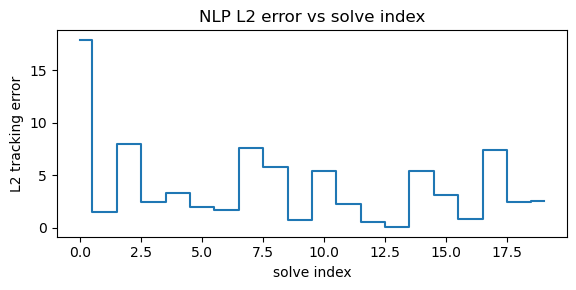

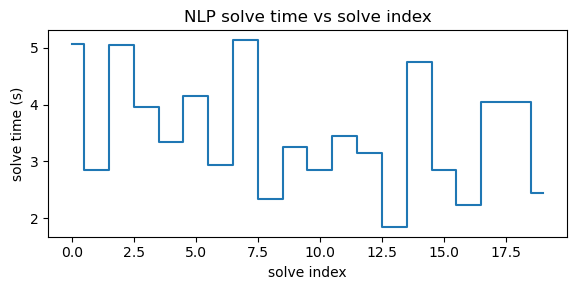

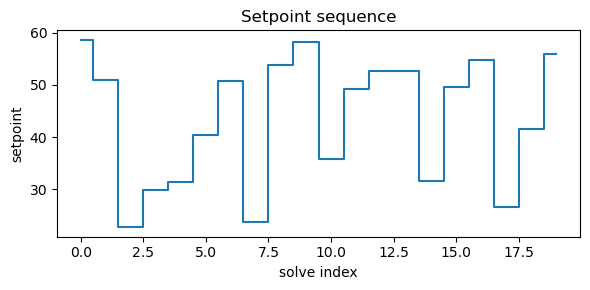

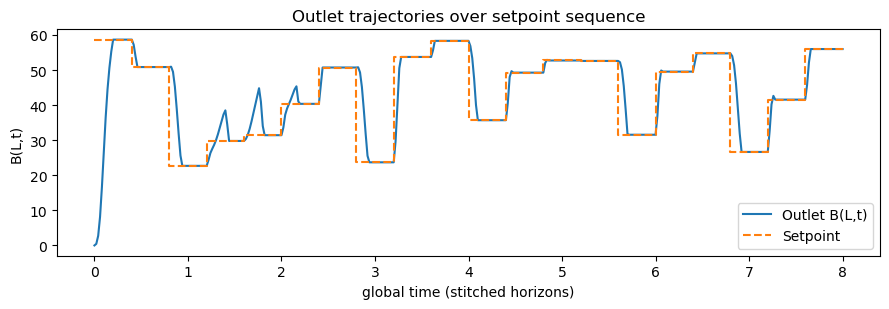

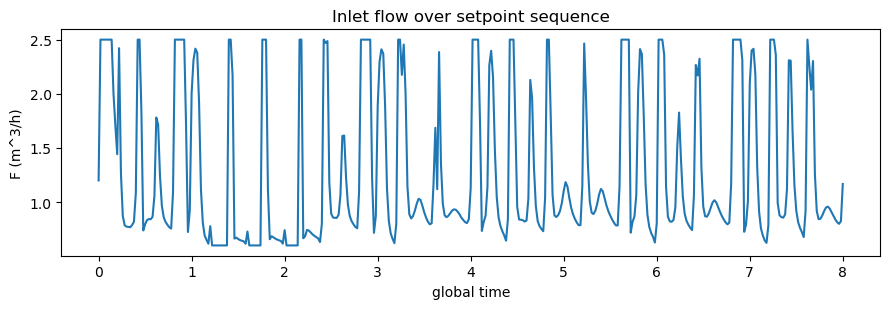

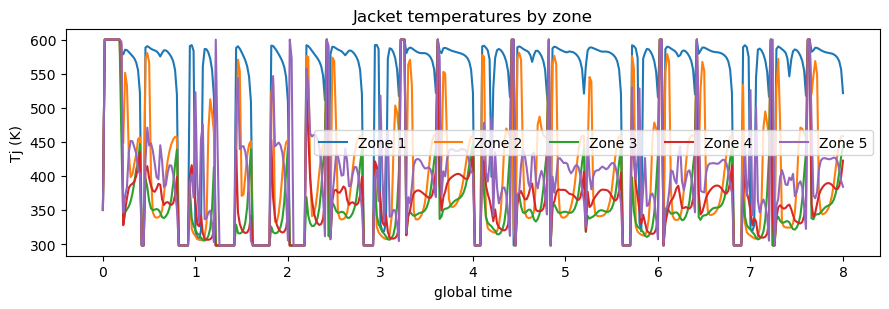

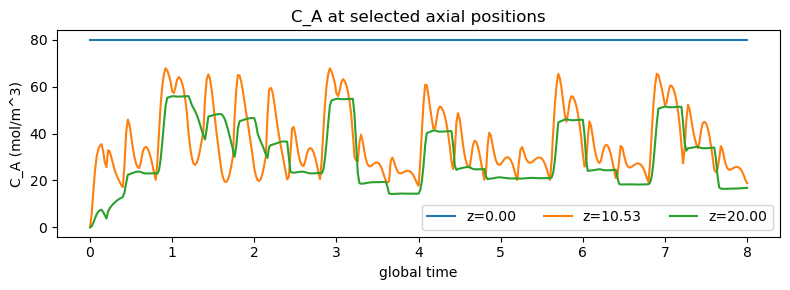

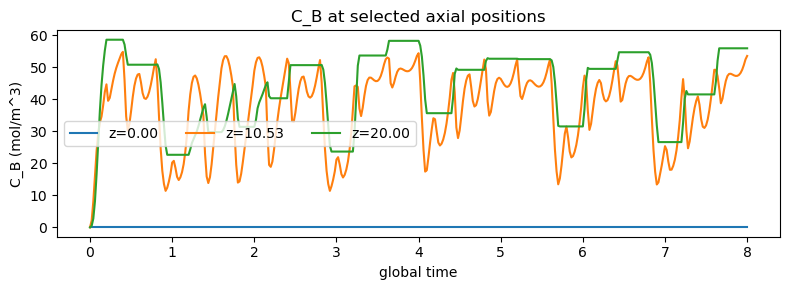

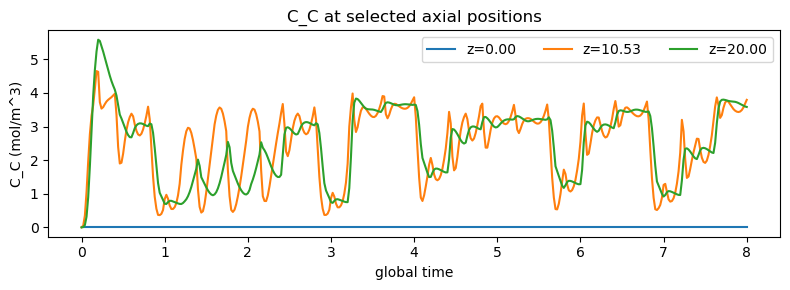

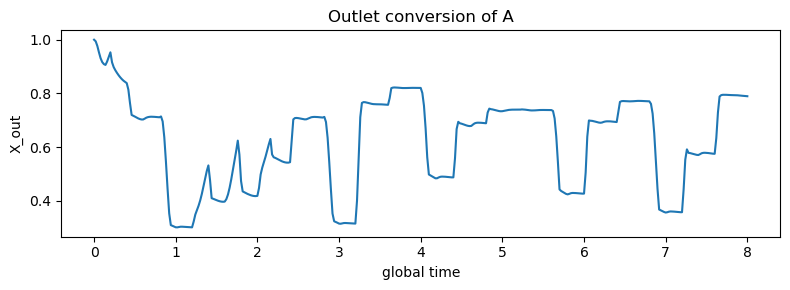

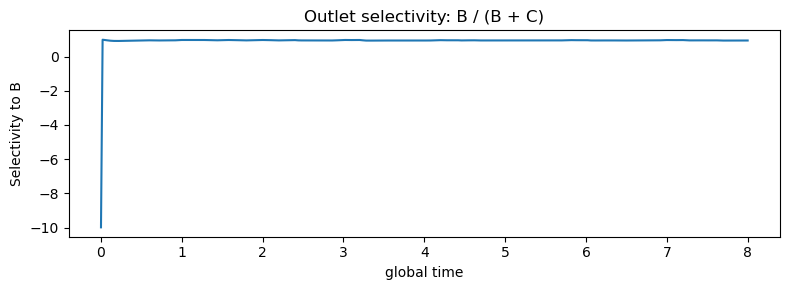

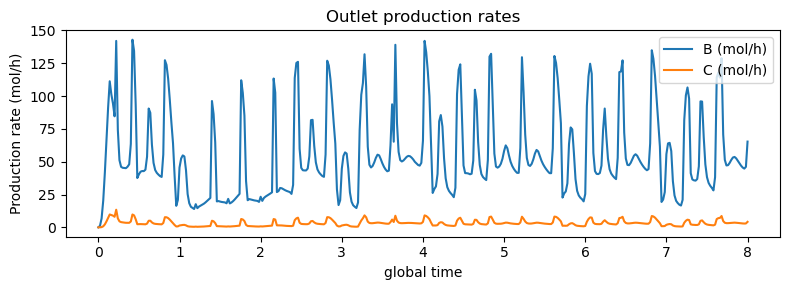

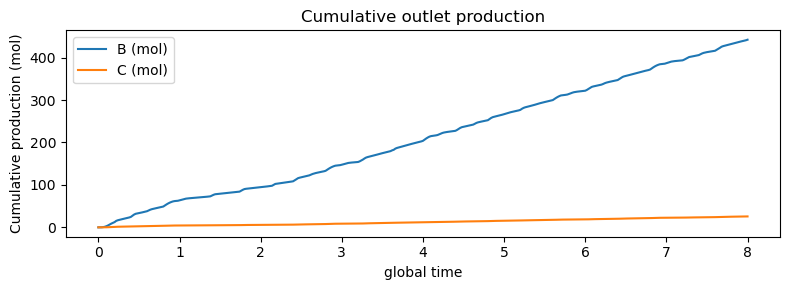

In [38]:
# quick sanity plots all_cold, meta_cold
plot_meta_over_solves(meta_cold)
plot_outlet_sequence(env_cold, all_cold)
plot_MVs_sequence(env_cold, all_cold)
plot_species_probes_sequence(env_cold, all_cold,
                             probes=("inlet", "middle", "outlet"))
plot_outlet_metrics_sequence(env_cold, all_cold)

plt.show()

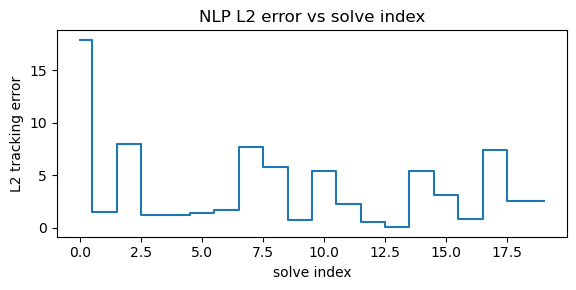

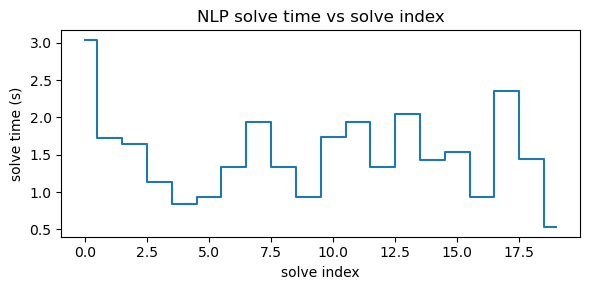

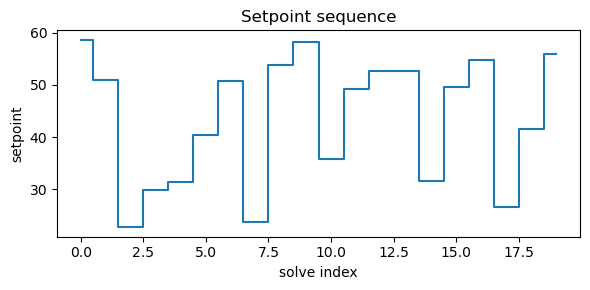

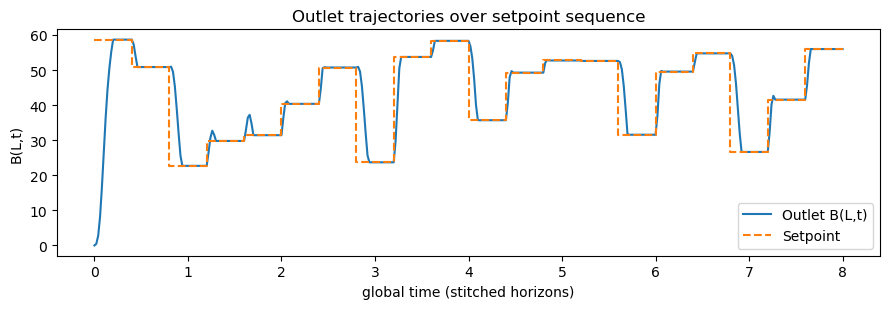

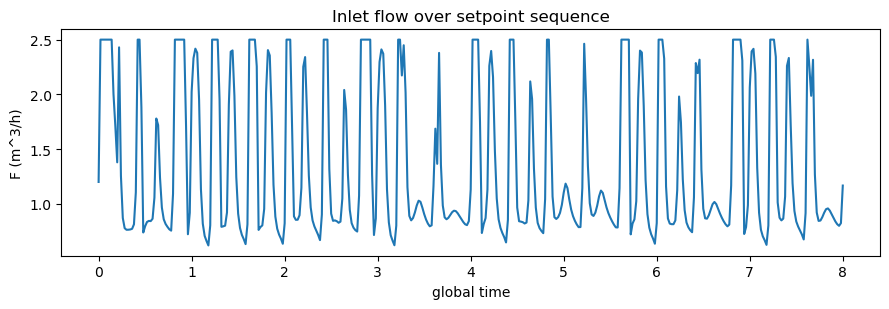

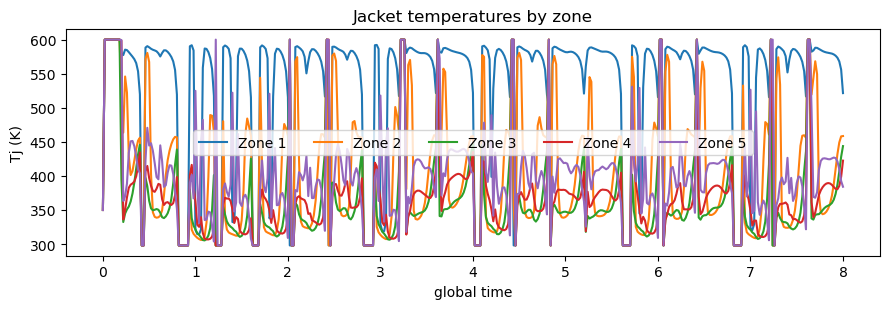

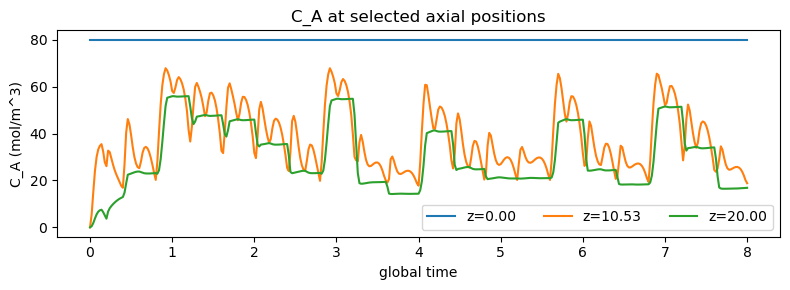

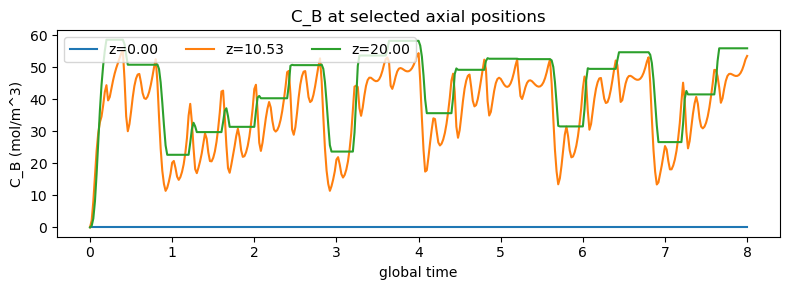

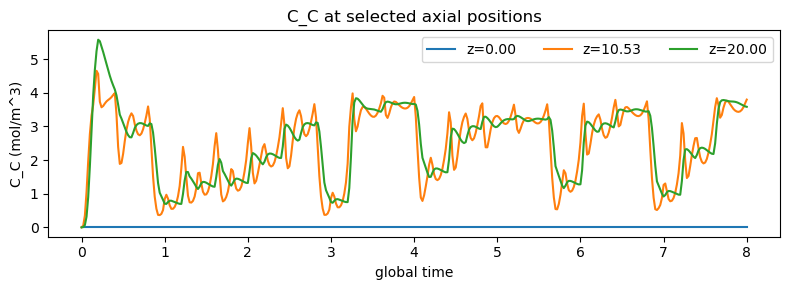

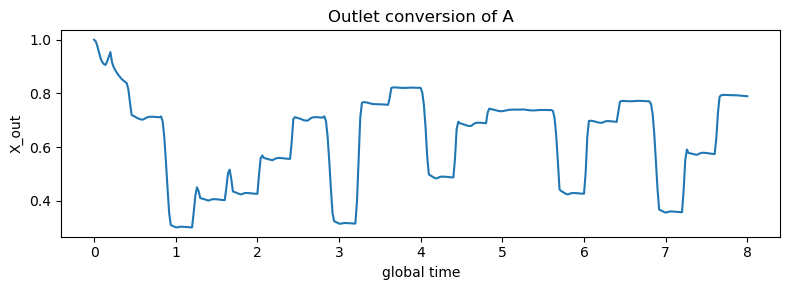

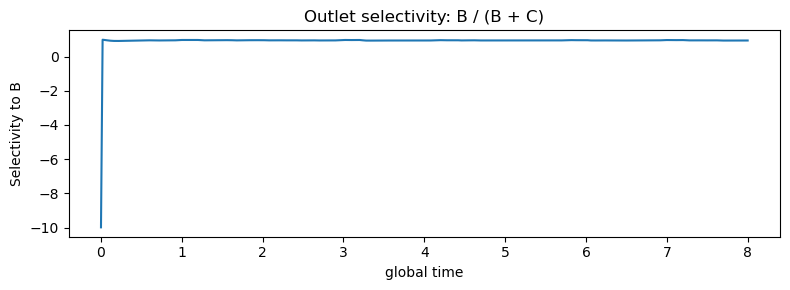

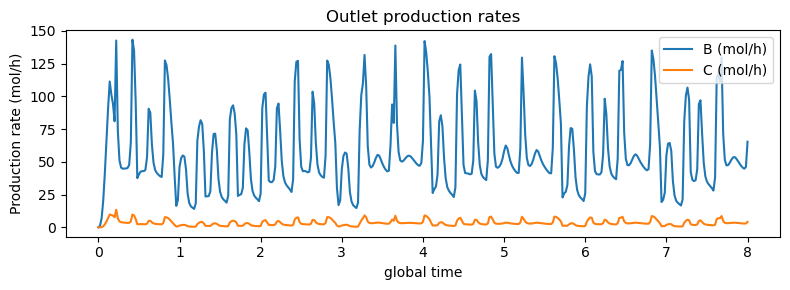

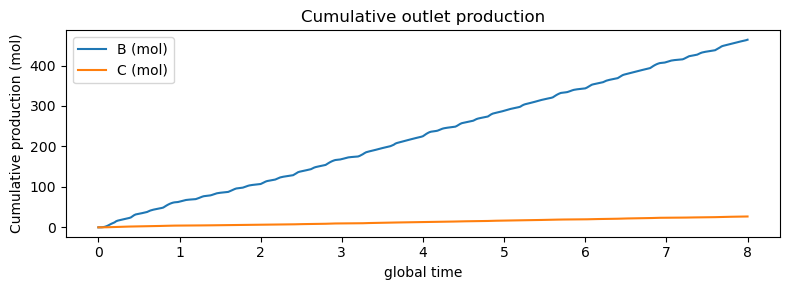

In [39]:
# quick sanity plots all_cold, meta_cold
plot_meta_over_solves(meta_warm)
plot_outlet_sequence(env_warm, all_warm)
plot_MVs_sequence(env_warm, all_warm)
plot_species_probes_sequence(env_warm, all_warm,
                             probes=("inlet", "middle", "outlet"))
plot_outlet_metrics_sequence(env_warm, all_warm)

plt.show()